# Linear Regression Modeling using Kaggles CapitalBikeShare dataset

## explanatory data analysis and linear regression modeling using scikit-learn

This notebook provides all necessary information to obtain trends and features from the dataset, which are subsequently used to implement a linear regression model. \
During the modeling different regression methods are furthermore compared regarding performance and computing time.

####  the data for this analysis can be downloaded from:
https://www.kaggle.com/c/bike-sharing-demand/data?select=train.csv

#### Data Fields in the table and additional explanations:

**datetime** - hourly date + timestamp \
**season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter \
**holiday** - whether the day is considered a holiday \
**workingday** - whether the day is neither a weekend nor holiday \
**weather** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy \
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
**temp** - temperature in Celsius \
**atemp** - "feels like" temperature in Celsius \
**humidity** - relative humidity \
**windspeed** - wind speed \
**casual** - number of non-registered user rentals initiated \
**registered** - number of registered user rentals initiated \
**count** - number of total rentals

this data was reported for two years: 2011 and 2012

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as mpt



from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, PassiveAggressiveRegressor
from sklearn.linear_model import  RidgeCV, LassoCV, ElasticNetCV

from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#### data preprocessing and feature description:
- upon loading the data, the 'count' column is set to be the variable to be predicted (while the columns 'casual' and 'registered' sum up to the 'count'- column and should not be used during feature engineering, they still hold interesting observations about the behaviour of these 2 different classes of customers)
- as the very first step, the datetime column will be transformed to the pandas-datetime format, of which month, weekdays, and hours of the day are extracted using a small helper function: day_and_time_from_datetime(df)
- the data is split into train and a test subset 
- afterwards it is assessed for missing values

In [2]:
def day_and_time_from_datetime(df):
    '''
    this helper function extracts hour, day, and month from the datetime column.
    
    Params:
    -------
        input: dataframe with the Kaggle bicycle data
        output:new dataframe with the date column transformed to pandas datetime-features
    '''
    df = df.copy()
    df['time [h]'] = pd.to_datetime(df['datetime']).dt.hour
    df['weekday'] = pd.to_datetime(df['datetime']).dt.dayofweek
    df['month'] = pd.to_datetime(df['datetime']).dt.month
    df = df.drop('datetime', axis = 1)
    return df

In [4]:
df = pd.read_csv("./data/train.csv")
y = df['count'] 
X = df.drop(columns= ['count'])
df.shape

(10886, 12)

In [120]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, random_state = 42)

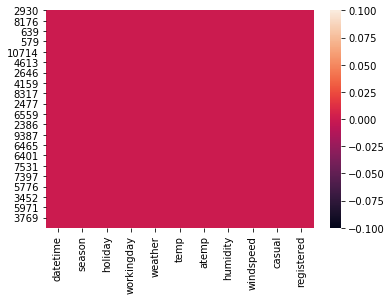

In [121]:
sns.heatmap(Xtrain.isna())

#### exploratory plotting to visualize as much as possible information

In [101]:
df = day_and_time_from_datetime(df)

Text(0.5, 1.0, 'differences in bicyle usage throughout the day')

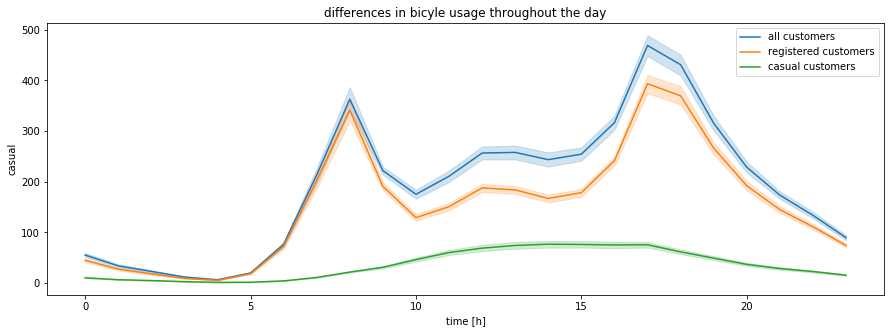

In [26]:
plt.figure(figsize = (15,5))
sns.lineplot(x = 'time [h]', y =  'count', data = df, label = 'all customers')
sns.lineplot(x = 'time [h]', y =  'registered', data = df, label = 'registered customers')
sns.lineplot(x = 'time [h]', y =  'casual', data = df, label = 'casual customers')
plt.title('differences in bicyle usage throughout the day')

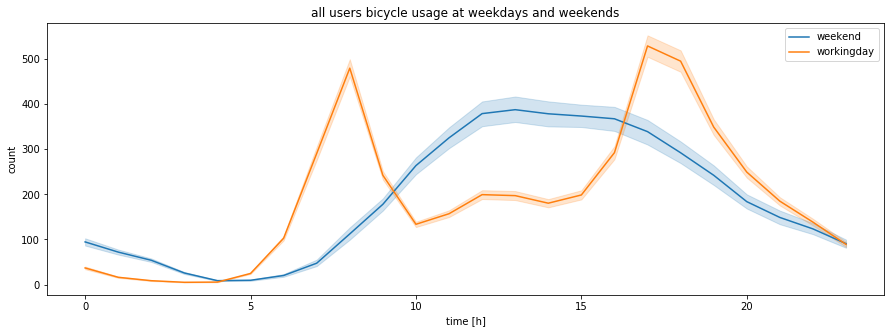

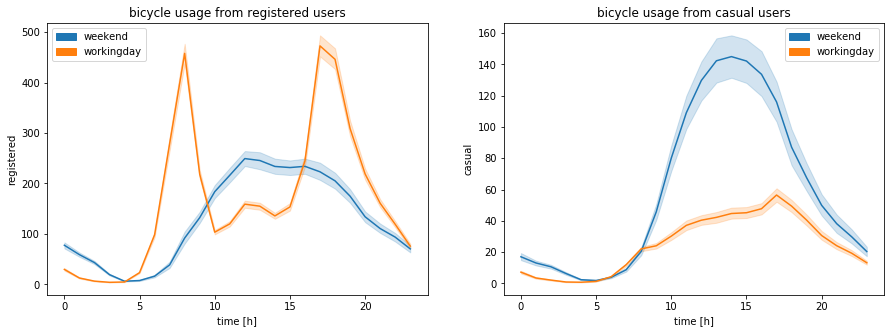

In [61]:
plt.figure(figsize = (15,5))
orange_patch = mpt.Patch(color = sns.color_palette()[1], label = 'workingday')
blue_patch = mpt.Patch(color = sns.color_palette()[0], label = 'weekend')

sns.lineplot( x = 'time [h]', y = 'count', hue = 'workingday', data = df)
plt.legend(labels =  ['weekend', 'workingday'])
plt.title('all users bicycle usage at weekdays and weekends')

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
sns.lineplot( x = 'time [h]', y = 'registered', hue = 'workingday', data = df, ax = ax1)
sns.lineplot(x = 'time [h]', y = 'casual', hue = 'workingday', data = df, ax = ax2)
ax1.set_title('bicycle usage from registered users')
ax2.set_title('bicycle usage from casual users')
ax1.legend(handles = [ blue_patch, orange_patch])
ax2.legend(handles = [ blue_patch, orange_patch])

plt.show()

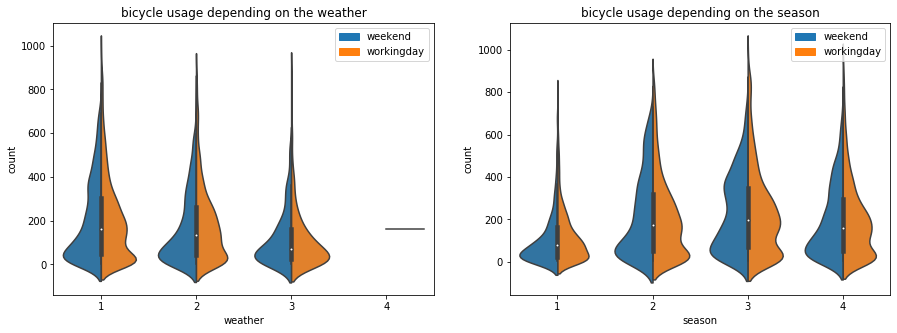

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
orange_patch = mpt.Patch(color = sns.color_palette()[1], label = 'workingday')
blue_patch = mpt.Patch(color = sns.color_palette()[0], label = 'weekend')

sns.violinplot(x = 'weather', y = 'count', data = df, hue = 'workingday', split = True, ax = ax1)
sns.violinplot(x = 'season', y = 'count', data = df, hue = 'workingday', split = True, ax = ax2)

ax1.set_title('bicycle usage depending on the weather')
ax2.set_title('bicycle usage depending on the season')

ax1.legend(handles = [ blue_patch, orange_patch])
ax2.legend(handles = [ blue_patch, orange_patch])
plt.show()

Text(0.5, 1.0, 'correlation between bicycle usage and humidity')

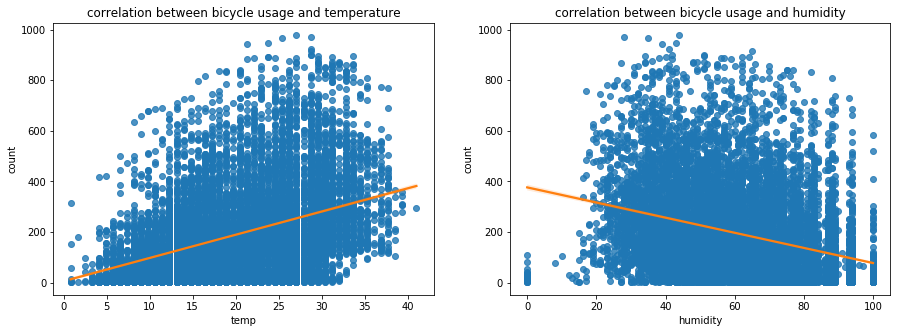

In [106]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
sns.regplot(x = 'temp', y = 'count', data = df, ax = ax1, line_kws={"color": sns.color_palette()[1]})
sns.regplot(x = 'humidity', y = 'count', data = df, ax = ax2, line_kws={"color": sns.color_palette()[1]})

ax1.set_title('correlation between bicycle usage and temperature')
ax2.set_title('correlation between bicycle usage and humidity')

## summary of observations:
- bicycle usage is day-time dependent
    - on workingdays there are two peaks that roughly correspond to usage by registered users getting to and from work.
    - on weekends, there seems to be rather a peak around noon, mainly related to casual users.
- registered users make the largest part of all users, casual ones peak only occasionally, mainly during the weekends
- neither weather nore season seems to matter much, except for weather == 4 as this corresponds to thunderstorms, where there is very little data.
- a correlation with temperature seems likely

#### feature engineering and linear regression
(this must not include the columns 'casual' or 'registered' as these directly relate to the total count) \
The decission about the different regressors followed this excellent article by Quinn Lanners:
https://towardsdatascience.com/choosing-a-scikit-learn-linear-regression-algorithm-dd96b48105f5

In [122]:
# features from the original datetime-column are extracted, onehot-encoded and defined as interaction-features
time_feat = ['datetime']
time_transformer = Pipeline(steps=[
    ('day_time_extract', FunctionTransformer(day_and_time_from_datetime)),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('polynomial', PolynomialFeatures(interaction_only=True, include_bias=False))
    ])

# the numeric parameters windspeed and atemp are scaled to a mean-value of 0 and a variance of 1
numeric_features = ['windspeed', 'atemp']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ])

# categorical feature weather is onehot-encoded
categorical_features = ['weather']
categorical_transformer = Pipeline(steps=[   
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

# three more interacting features are defined: (humidity and workingday), (workingday and temp), and (workingday and season), all are onehot-encoded afterwards
interact_features1 = ['humidity' ,'workingday']
interaction_transformer1 = Pipeline(steps=[
    ('polynomial1', PolynomialFeatures(interaction_only = True, include_bias=False)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

interact_features2 = ['workingday' ,'temp']
interaction_transformer2 = Pipeline(steps=[
    ('polynomial2', PolynomialFeatures(interaction_only = True, include_bias=False)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

interact_features3 = ['workingday' ,'season']
interaction_transformer3 = Pipeline(steps=[
    ('polynomial3', PolynomialFeatures(interaction_only = True, include_bias=False)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

In [123]:
preprocessor = ColumnTransformer(
    transformers=[
        ('day_time_extract', time_transformer, time_feat),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('polynomial1', interaction_transformer1, interact_features1),
        ('polynomial2', interaction_transformer2, interact_features2),
        ('polynomial3', interaction_transformer3, interact_features3)
        ])

In [124]:
p = Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', LinearRegression())
                    ])

In [128]:
p.fit(Xtrain, ytrain)
ypred_train = p.predict(Xtrain)
print(f'MSE from LinReg: ' + str(mean_squared_error(ytrain, ypred_train)))
print('MAE from LinReg: ' + str(mean_absolute_error(ytrain, ypred_train)))
print('r2 from LinReg: ' + str(r2_score(ytrain, ypred_train)))

MSE from LinReg: 5319.669254260184
MAE from LinReg: 53.178878877915466
r2 from LinReg: 0.8378586206811961


#### comparison of different regressors

In [467]:
param_grid_reg = {
    'classifier' : [LinearRegression(), Ridge(), Lasso(), ElasticNet(), LinearSVR(), SGDRegressor(), PassiveAggressiveRegressor(), KNeighborsRegressor(), DecisionTreeRegressor(),  GradientBoostingRegressor()] 
}
grid_search_reg = GridSearchCV(p, param_grid_reg)

In [505]:
#grid_search_reg.fit(Xtrain, ytrain) 
GS_reg = pd.DataFrame(grid_search_reg.cv_results_)
GS_reg

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.336228,0.040279,0.038842,0.007475,LinearRegression(),{'classifier': LinearRegression()},0.770944,0.789554,0.807343,0.806328,0.792015,0.793237,0.013285,3
1,0.109776,0.006134,0.037638,0.004578,Ridge(),{'classifier': Ridge()},0.774657,0.792605,0.808097,0.809429,0.793932,0.795744,0.012631,1
2,0.247424,0.011333,0.040025,0.003315,Lasso(),{'classifier': Lasso()},0.591378,0.639020,0.633290,0.634686,0.632354,0.626146,0.017533,7
3,0.149796,0.011896,0.042014,0.003682,ElasticNet(),{'classifier': ElasticNet()},0.218968,0.239261,0.224853,0.233708,0.226162,0.228590,0.007106,10
4,0.082297,0.005619,0.036781,0.001468,LinearSVR(),{'classifier': LinearSVR()},0.607235,0.621673,0.601791,0.588600,0.610413,0.605942,0.010836,8
5,0.359175,0.045419,0.036297,0.005423,SGDRegressor(),{'classifier': SGDRegressor()},0.773713,0.792190,0.808398,0.809030,0.792827,0.795232,0.012976,2
6,0.099002,0.006299,0.037473,0.003200,PassiveAggressiveRegressor(),{'classifier': PassiveAggressiveRegressor()},0.745045,0.769554,0.775749,0.777196,0.762915,0.766092,0.011676,4
7,0.089114,0.011074,0.747793,0.030823,KNeighborsRegressor(),{'classifier': KNeighborsRegressor()},0.571206,0.594524,0.594161,0.568405,0.600831,0.585825,0.013323,9
8,0.789199,0.021755,0.038711,0.003078,DecisionTreeRegressor(),{'classifier': DecisionTreeRegressor()},0.641986,0.665351,0.686538,0.695248,0.680007,0.673826,0.018678,6
9,1.179350,0.043818,0.040719,0.003292,GradientBoostingRegressor(),{'classifier': GradientBoostingRegressor()},0.710968,0.740826,0.724477,0.721918,0.722559,0.724150,0.009586,5


In [506]:
# for plotting perfomance of different regressors:
GS_reg = GS_reg.stack().unstack(0).reset_index()
GS_reg.set_index('index', inplace = True)
GS_reg.columns = param_grid_reg['classifier']
GS_reg.drop(['param_classifier','params'], inplace = True)

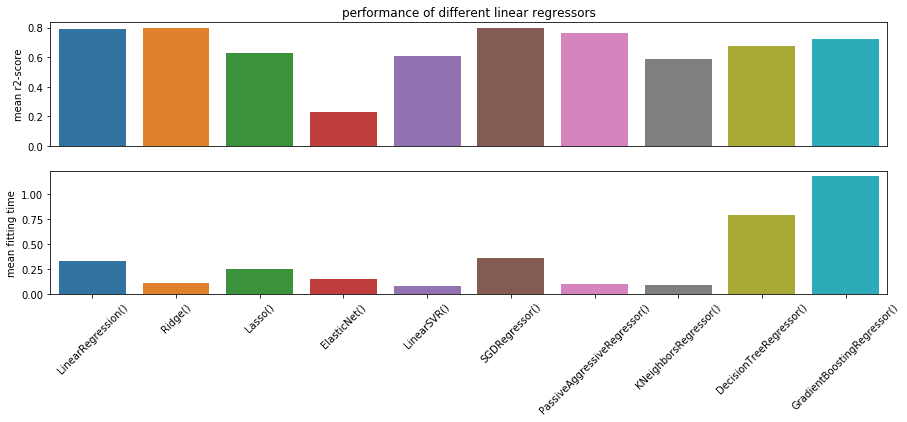

In [508]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,5))
ax1.set_title('performance of different linear regressors')

sns.barplot(y = GS_reg.iloc[0], x = GS_reg.columns, ax = ax2)
sns.barplot(y = GS_reg.iloc[9], x = GS_reg.columns, ax = ax1)
ax1.set_xticks([])
ax1.set_ylabel('mean r2-score')
ax2.set_ylabel('mean fitting time')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
plt.show()

#### result of the regressor comparison:
LinearRegression, Ridge and SGDRegressor show best performance, with Ridge beeing clearly faster. \
As the different regularization methods Ridge, Lasso and Elastic Net allow for CrossValidation and additional Hyperparameter optimization, this is tested next

In [509]:
param_grid_CV = {
    'classifier' : [ RidgeCV(), LassoCV(), ElasticNetCV()] 
}
grid_search_CV = GridSearchCV(p, param_grid_CV)

In [514]:
grid_search_CV.fit(Xtrain, ytrain) 
GS_CV = pd.DataFrame(grid_search_CV.cv_results_)

In [511]:
GS_score = GS_CV.stack().unstack(0).reset_index().iloc[6:11]
GS_score.rename(columns = {'index' :'index',  0: 'RidgeCV', 1: 'LassoCV', 2:'ElasticNetCV'}, inplace =True)

In [512]:
GS_t = pd.DataFrame(GS_CV.stack().unstack(0).reset_index().iloc[0])
GS_time = GS_t.T
GS_time.rename(columns = {'index' :'index',  0: 'RidgeCV', 1: 'LassoCV', 2:'ElasticNetCV'}, inplace =True)
GS_time.set_index('index', inplace = True)

Text(0.5, 1.0, 'mean fitting time cross validation')

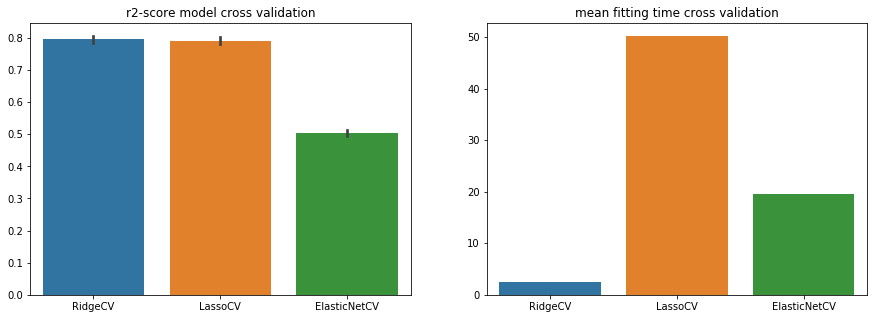

In [513]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
sns.barplot(data = GS_score, ax = ax1)
sns.barplot(data = GS_time, ax = ax2)
ax1.set_title('r2-score model cross validation')
ax2.set_title('mean fitting time cross validation')

#### after hyperparameter optimization Ridge regression performs best, both in terms of r2-score and in fitting time